# Regression Model Creation

## Import Libraries

In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Import Data from Pre-Processing
* Missing values HAVE been imputed.
* No PCA performed yet, no 1hot encoding. 


In [2]:
######################
#
# Import Data from PreProcessing
#
#####################

df= pd.read_csv('../_data/operations_imputed_CLEAN_v2.csv', index_col=0)

df.drop(['race'], axis=1, inplace=True)

In [ ]:
df.info()

### Create the X and y DataFrames for REGRESSION Model


  * create y
  * create X (complete with all the features)
  * drop the features we identified as not meeting impact threshold.
  *  * Target = `LOS` (continuous variable)  



In [3]:
# When doing a Categorical Model, reinsert 'prolonged_LOS' and instead, drop 'LOS'

## Features to retain are those in X that will be used in training. Exludued features are features such as Operation_ID, Subject_ID..
features_to_retain = ['category_id','age','sex',	'weight',	'height',	'hr',	'pip',	'pmean',	'rr',	'spo2',	'vt',	'chloride',	'creatinine',	'glucose',	'hb',	'hco3',	'lymphocyte',	'platelet',	'potassium',	'sodium',	'total_bilirubin',	'wbc',	'icu_visit',	'or_duration',	'anesth_duration',	'department','antype'] 

# Cast the 'LOS' column to a string (need to do this for a CATEGORIZATION problem)
y= df['LOS'].round().astype(int).astype(str)

## Create X the Features for Train/Test/Validate
X = df.drop('LOS', axis=1)
X= X[features_to_retain]



## Training-Test-Validation Split

- Training Set (80% of total): 
  - Used to train the models.
- Validation Set (20% of Traning Set ): 
  - Used to fine-tune hyperparameters, select models, and monitor training progress.  
- Testing Set (20% of total): 
  - Used to evaluate the final model's performance on unseen data and estimate its generalization performance.

In [4]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = .2
TRAINING_SPLIT = 1-TEST_SPLIT
VALIDATION_SPLIT = .2


def split_data(X, y, test_split=0.2, validation_split=0.2, random_state=None):
    """
    Splits data into training, validation, and test sets.

    Parameters:
    - X: Features data.
    - y: Target variable.
    - test_split: Fraction of the data to be used as test set.
    - validation_split: Fraction of the training data to be used as validation set.
    - random_state: Seed for the random number generator.

    Returns:
    A dictionary containing the split data.
    """

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, random_state=random_state)

    # Adjust validation split to account for the initial test split
    validation_size = validation_split / (1 - test_split)

    # Split the training data again into training and validation sets
    X_train, X_validate, y_train, y_validate = train_test_split(
        X_train, y_train, test_size=validation_size, random_state=random_state)

    # Create a dictionary to hold the data splits
    data_splits = {
        'X_train': X_train,
        'X_validate': X_validate,
        'X_test': X_test,
        'y_train': y_train,
        'y_validate': y_validate,
        'y_test': y_test
    }

    return X_train, X_validate, X_test, y_train, y_validate, y_test


'''# Example usage:
# Assuming X and y are your data and labels
data_splits = split_data(X, y, test_split=TEST_SPLIT, validation_split=VALIDATION_SPLIT, random_state=85100)

# Print the shapes of the splits
for key, value in data_splits.items():
    shape = value.shape
    print(f"{key} shape: {shape}")'''

## Call data split function:
X_train, X_validate, X_test, y_train, y_validate, y_test = split_data(X, y,test_split=TEST_SPLIT,
    validation_split=VALIDATION_SPLIT,random_state=85100)

# Define Pipeline
* This section is limited to establishing the pre-processing pipeline. 
* calling the pipeline is after the data has been split. 
  

In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer,OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

COLS_TO_CAST = ['category_id','antype','sex','department', 'icu_visit']

# Define the columns that you want to scale and cast to strings
numeric_features = X.select_dtypes(include=['int', 'float']).columns
string_features =  COLS_TO_CAST

# Define transformers
numeric_transformer = StandardScaler()
string_transformer = FunctionTransformer(lambda x: x.astype(str), validate=False)
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('one_hot', onehot_encoder, string_features)],
        remainder='passthrough')  # Leaves the rest of the columns alone)

# Create a full pipeline by combining with an estimator, for example, a classifier
model_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())])


## MODEL 

### Logistic Regression - Baseline

In [6]:
#########################
#
#  SIMPLE LINEAR REGRESSION Pipeline -
#  -- No tuning. 
########################

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model_log.fit(X_train, y_train)

y_pred_log = model_log.predict(X_validate)


In [7]:
from sklearn import set_config
set_config(display='diagram')
model_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['age', 'weight', 'height', 'hr', 'pip', 'pmean', 'rr', 'spo2', 'vt',
       'chloride', 'creatinine', 'glucose', 'hb', 'hco3', 'lymphocyte',
       'platelet', 'potassium', 'sodium', 'total_bilirubin', 'wbc',
       'icu_visit', 'or_duration', 'anesth_duration'],
      dtype='object')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category_id', 'antype',
                                                   'sex', 'department',
                                                   'icu_visit'])])),
                ('classifier', LogisticRegression())])

In [8]:
result_data = pd.DataFrame(columns = ["Model_Name","Sensitivity", "Specificity", "Accuracy"])

In [9]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(y_true, y_pred,modelname="Model"):
    print("True labels:")
    print(y_true)
    print("\nPredicted labels:")
    print(y_pred)
    
    
    
    accuracy = round(accuracy_score(y_true, y_pred), 2)
    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    
    
    sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.title("Accuracy Score: {0}".format(accuracy), size=10)
    plt.show()

    # Extract values from the confusion matrix
    TN, FP, FN, TP = cm.ravel()

    # Calculate Sensitivity (True Positive Rate)
    sensitivity = TP / (TP + FN)

    # Calculate Specificity (True Negative Rate)
    specificity = TN / (TN + FP)
    
    # Append the values to the Results DataFrame
    result_data.loc[len(result_data)] = [modelname,sensitivity, specificity,accuracy]
    
    print(classification_report(y_true, y_pred))
         
    return sensitivity, specificity, accuracy




True labels:
68863      0
80846     42
59973      1
120742     3
104856     2
          ..
79656      9
68600      1
87307      1
29994      0
123177     1
Name: LOS, Length: 15349, dtype: object

Predicted labels:
['1' '54' '1' ... '0' '1' '2']


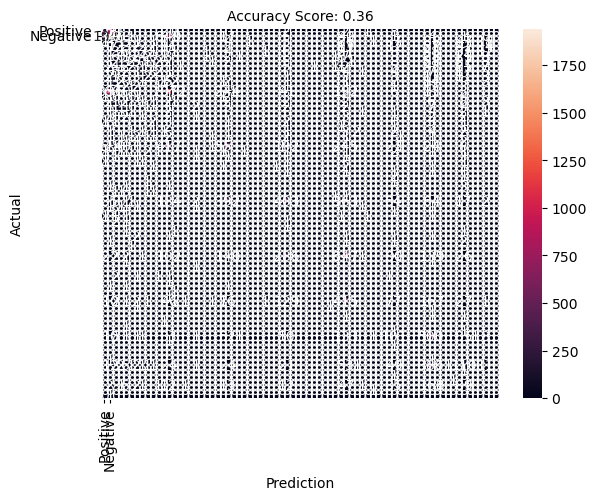

ValueError: too many values to unpack (expected 4)

In [10]:
sensitivity_log, specificity_log, accuracy_log = plot_confusion_matrix(y_validate, y_pred_log, "Logistic Regression")  # Capture the returned values

result_data

--------------------------
CODE ABOVE WORKS - but NEED TO GROUP LOS into BUCKETS!!! 


## Model Deployment


In [ ]:
import pickle

with open('../_output/catboost_model_regression_opt.pickle', 'wb') as f:
    pickle.dump(cat_model_lin, f)
